In [2]:
# ! pip install fastcore
# ! pip install --upgrade fastai

#### Imports

In [3]:
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
import torchvision.models as tvm
from torchvision.transforms import *

import torch
import torch.nn.functional as F
from fastai.losses import *
from fastai.vision.all import *
from fastai.metrics import JaccardCoeff, Dice

#from torchgeometry.losses.tversky import tversky_loss, TverskyLoss
#from kornia.losses import TverskyLoss
import glob

In [319]:
def FileSplitter(valid_fnames):
    "Split `items` depending on the value of `mask`."
    def _func(x): return x.name in valid_fnames
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

def fg_accuracy(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != 0
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

def bg_accuracy(inp, targ):
  targ = targ.squeeze(1)
  mask = targ == 0
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

class IOU(AvgMetric):
    "Intersection over Union Metric"
    def __init__(self, class_index, class_label, axis, ignore_index=-1): store_attr('axis,class_index,class_label,ignore_index')
    def accumulate(self, learn):
        pred, targ = learn.pred.argmax(dim=self.axis), learn.y
        intersec = ((pred == targ) & (targ == self.class_index)).sum().item()
        union = (((pred == self.class_index) | (targ == self.class_index)) & (targ != self.ignore_index)).sum().item()
        if union: self.total += intersec
        self.count += union
  
    @property
    def name(self): return self.class_label

class CombinedLoss:
  "Dice and Focal combined"
  def __init__(self, axis=1, smooth=1., alpha=1.):
      store_attr()
      self.focal_loss = FocalLossFlat(axis=axis)
      self.dice_loss =  DiceLoss(axis, smooth)
      
  def __call__(self, pred, targ):
      return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
  
  def decodes(self, x):    return x.argmax(dim=self.axis)
  def activation(self, x): return F.softmax(x, dim=self.axis)

@delegates()
class TstLearner(Learner):
    def __init__(self,dls=None,model=None,**kwargs): self.pred,self.xb,self.yb = None,None,None

#Go through a fake cycle with various batch sizes and computes the value of met
def compute_val(met, x1, x2):
    met.reset()
    vals = [0,6,15,20]
    learn = TstLearner()
    for i in range(3):
        learn.pred,learn.yb = x1[vals[i]:vals[i+1]],(x2[vals[i]:vals[i+1]],)
        met.accumulate(learn)
    return met.value

def plot_test_results(dls_tst, fnames, idx):
  dl_sample = dls_tst.test_dl(test_items = [tst_fnames[idx]], with_labels=True)

  plt.figure(figsize = (20,5))
  preds, targs = learn.get_preds(dl=dl_sample)
  pred_1 = preds[0]

  img = PILImage.create(tst_fnames[idx])
  plt.subplot(131)
  plt.imshow(img)

  plt.subplot(132)
  plt.imshow(targs[0])

  pred_arx = pred_1.argmax(dim=0)
  plt.subplot(133)
  plt.imshow(pred_arx)

#### Read Data

In [18]:
base_pth = '/content/drive/MyDrive/binary_lane_bdd'

img_pth = os.path.join(base_pth, 'images_sample/100k_sample/train')
lbl_pth = os.path.join(base_pth, 'lane_sample/masks/train')
binary_lbl_pth = os.path.join(base_pth, 'lane_binary_sample/masks/train')

tst_pth = os.path.join(base_pth, 'Images_here')
tst_binary_lbl_pth = os.path.join(base_pth, 'Labels Binary_here')

In [19]:
img_files = [i.replace('.jpg','') for i in os.listdir(img_pth)]
msk_files = [i.replace('.png','') for i in os.listdir(binary_lbl_pth)]

tst_files = [i.replace('.jpg','') for i in os.listdir(tst_pth)]
tst_files = list(set(tst_files) - set(img_files))
msk_files = tst_files

In [20]:
file_df = pd.DataFrame(os.listdir(img_pth)[1:], columns = ['filename'])
train_df, val_df = train_test_split(file_df, test_size = 0.2, random_state = 42)
valid_fnames = list(val_df['filename'].values)
tst_fnames = [i+'.jpg' for i in tst_files]

In [345]:
train_df.shape

(5599, 1)

In [346]:
val_df.shape

(1400, 1)

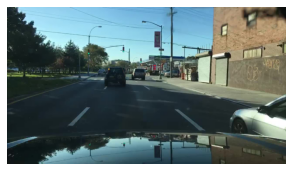

In [349]:
fnames = get_image_files(img_pth)
lbl_names = get_image_files(binary_lbl_pth)

tst_fnames = get_image_files(tst_pth)
tst_lbl_names = get_image_files(tst_binary_lbl_pth)

img_fn = fnames[0]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [48]:
get_msk = lambda o: Path(o.as_posix().replace('images_sample/100k_sample','lane_binary_sample/masks').replace('.jpg','.png'))
get_msk_tst = lambda o: Path(o.as_posix().replace('Images_here','Labels Binary_here').replace('.jpg','.png'))

In [49]:
# Calculate the Class Weight
master_out = []
for img_fn in tqdm_notebook(fnames[:2]):
  msk = PILMask.create(get_msk(img_fn))
  #msk.show(figsize=(5,5), alpha=1)
  out1, out2 = np.unique(msk, return_counts=True)
  master_out.append(out2)

class_weight_df = pd.DataFrame(master_out, columns = ['cnt_0', 'cnt_1'])
class_weight_df['weight_0'] = (720*1280)/(2*class_weight_df['cnt_0'])
class_weight_df['weight_1'] = (720*1280)/(2*class_weight_df['cnt_1'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
codes = ['0','1']

In [51]:
sz = msk.shape; sz

(720, 1280)

In [52]:
# For Resizing Image
half = tuple(int(x/2) for x in sz);
quarter = tuple(int(x/4) for x in sz);

In [53]:
quarter

(180, 320)

In [54]:
# Define Train Data Loader
bdd = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(mult=1.0,
                                               do_flip=True,
                                               flip_vert=False,
                                               max_rotate=20.0,
                                               min_zoom=0.75,
                                               max_zoom=1.25,
                                               max_lighting=0.7,
                                               max_warp=0.2,
                                               p_affine=0.75,
                                               p_lighting=0.75,
                                               xtra_tfms=[GaussianBlur(kernel_size=5)],
                                               size=half,
                                               mode='bilinear',
                                               pad_mode='reflection',
                                               align_corners=True,
                                               batch=False,
                                               min_scale=1.0),
                               Normalize.from_stats(*imagenet_stats)])
dls = bdd.dataloaders(img_pth, bs=8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [58]:
# Define Test Data Loader
bdd_tst = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(tst_fnames),
                   get_y=get_msk_tst,
                   batch_tfms=[*aug_transforms(mult=1.0,
                                               do_flip=True,
                                               flip_vert=False,
                                               max_rotate=20.0,
                                               min_zoom=0.75,
                                               max_zoom=1.25,
                                               max_lighting=0.7,
                                               max_warp=0.2,
                                               p_affine=0.75,
                                               p_lighting=0.75,
                                               xtra_tfms=[GaussianBlur(kernel_size=5)],
                                               size=half,
                                               mode='bilinear',
                                               pad_mode='reflection',
                                               align_corners=True,
                                               batch=False,
                                               min_scale=1.0),
                               Normalize.from_stats(*imagenet_stats)])
dls_tst = bdd_tst.dataloaders(tst_pth, bs=8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


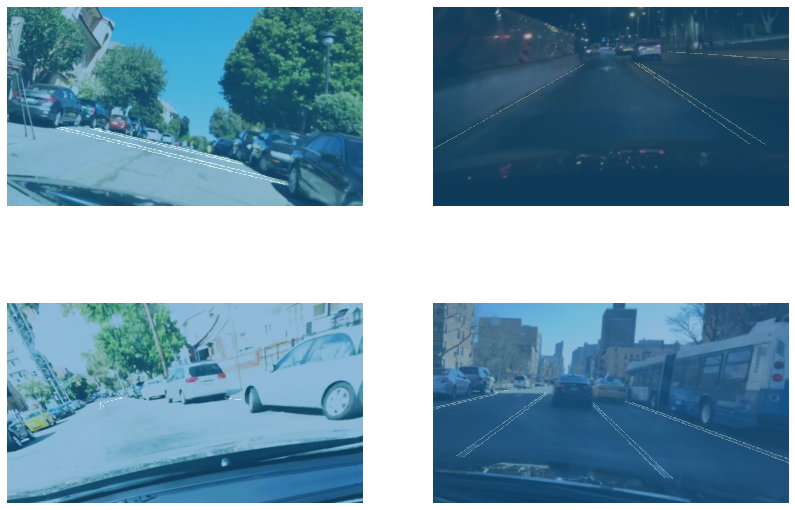

In [59]:
dls.show_batch(max_n=2, vmin=0, vmax=1, figsize=(14,10))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


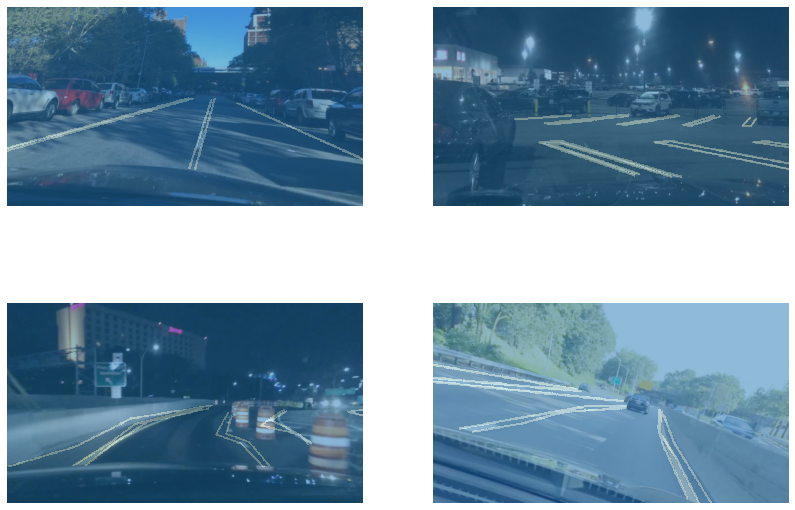

In [61]:
dls_tst.show_batch(max_n=4, vmin=0, vmax=1, figsize=(14,10))

In [77]:
dls.vocab = codes
dls_tst.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
opt = ranger
weights = torch.Tensor([0.5, 100])


bg_iou = IOU(class_index = 0, class_label = 'Not-Lane', axis=1)
fg_iou = IOU(class_index = 1, class_label = 'Lane', axis=1)

In [82]:
learn = unet_learner(dls,
                     tvm.resnet34,
                     metrics=[fg_accuracy, bg_accuracy, fg_iou, bg_iou, JaccardCoeff(), Dice()],
                     self_attention=True,
                     act_cls=Mish,
                     opt_func=opt,
                     pretrained=True,
                     loss_func=CombinedLoss(axis=1, smooth=1, alpha = 0.01))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [83]:
learn.summary()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


DynamicUnet (Input shape: 8 x 3 x 360 x 640)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 320  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 90 x 160   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=7.585775892948732e-05)

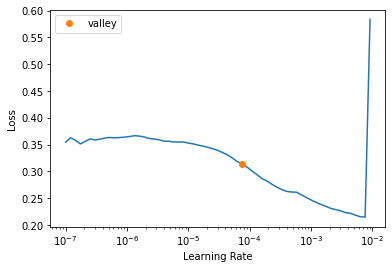

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


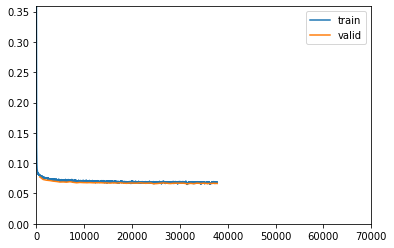

No improvement since epoch 44: early stopping


In [ ]:
learn.fit_flat_cos(100, slice(lr),
                   cbs=[
                        ShowGraphCallback(),
                        EarlyStoppingCallback(monitor='valid_loss', comp=None, min_delta=0.0, patience=10, reset_on_fit=True)
                        ])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


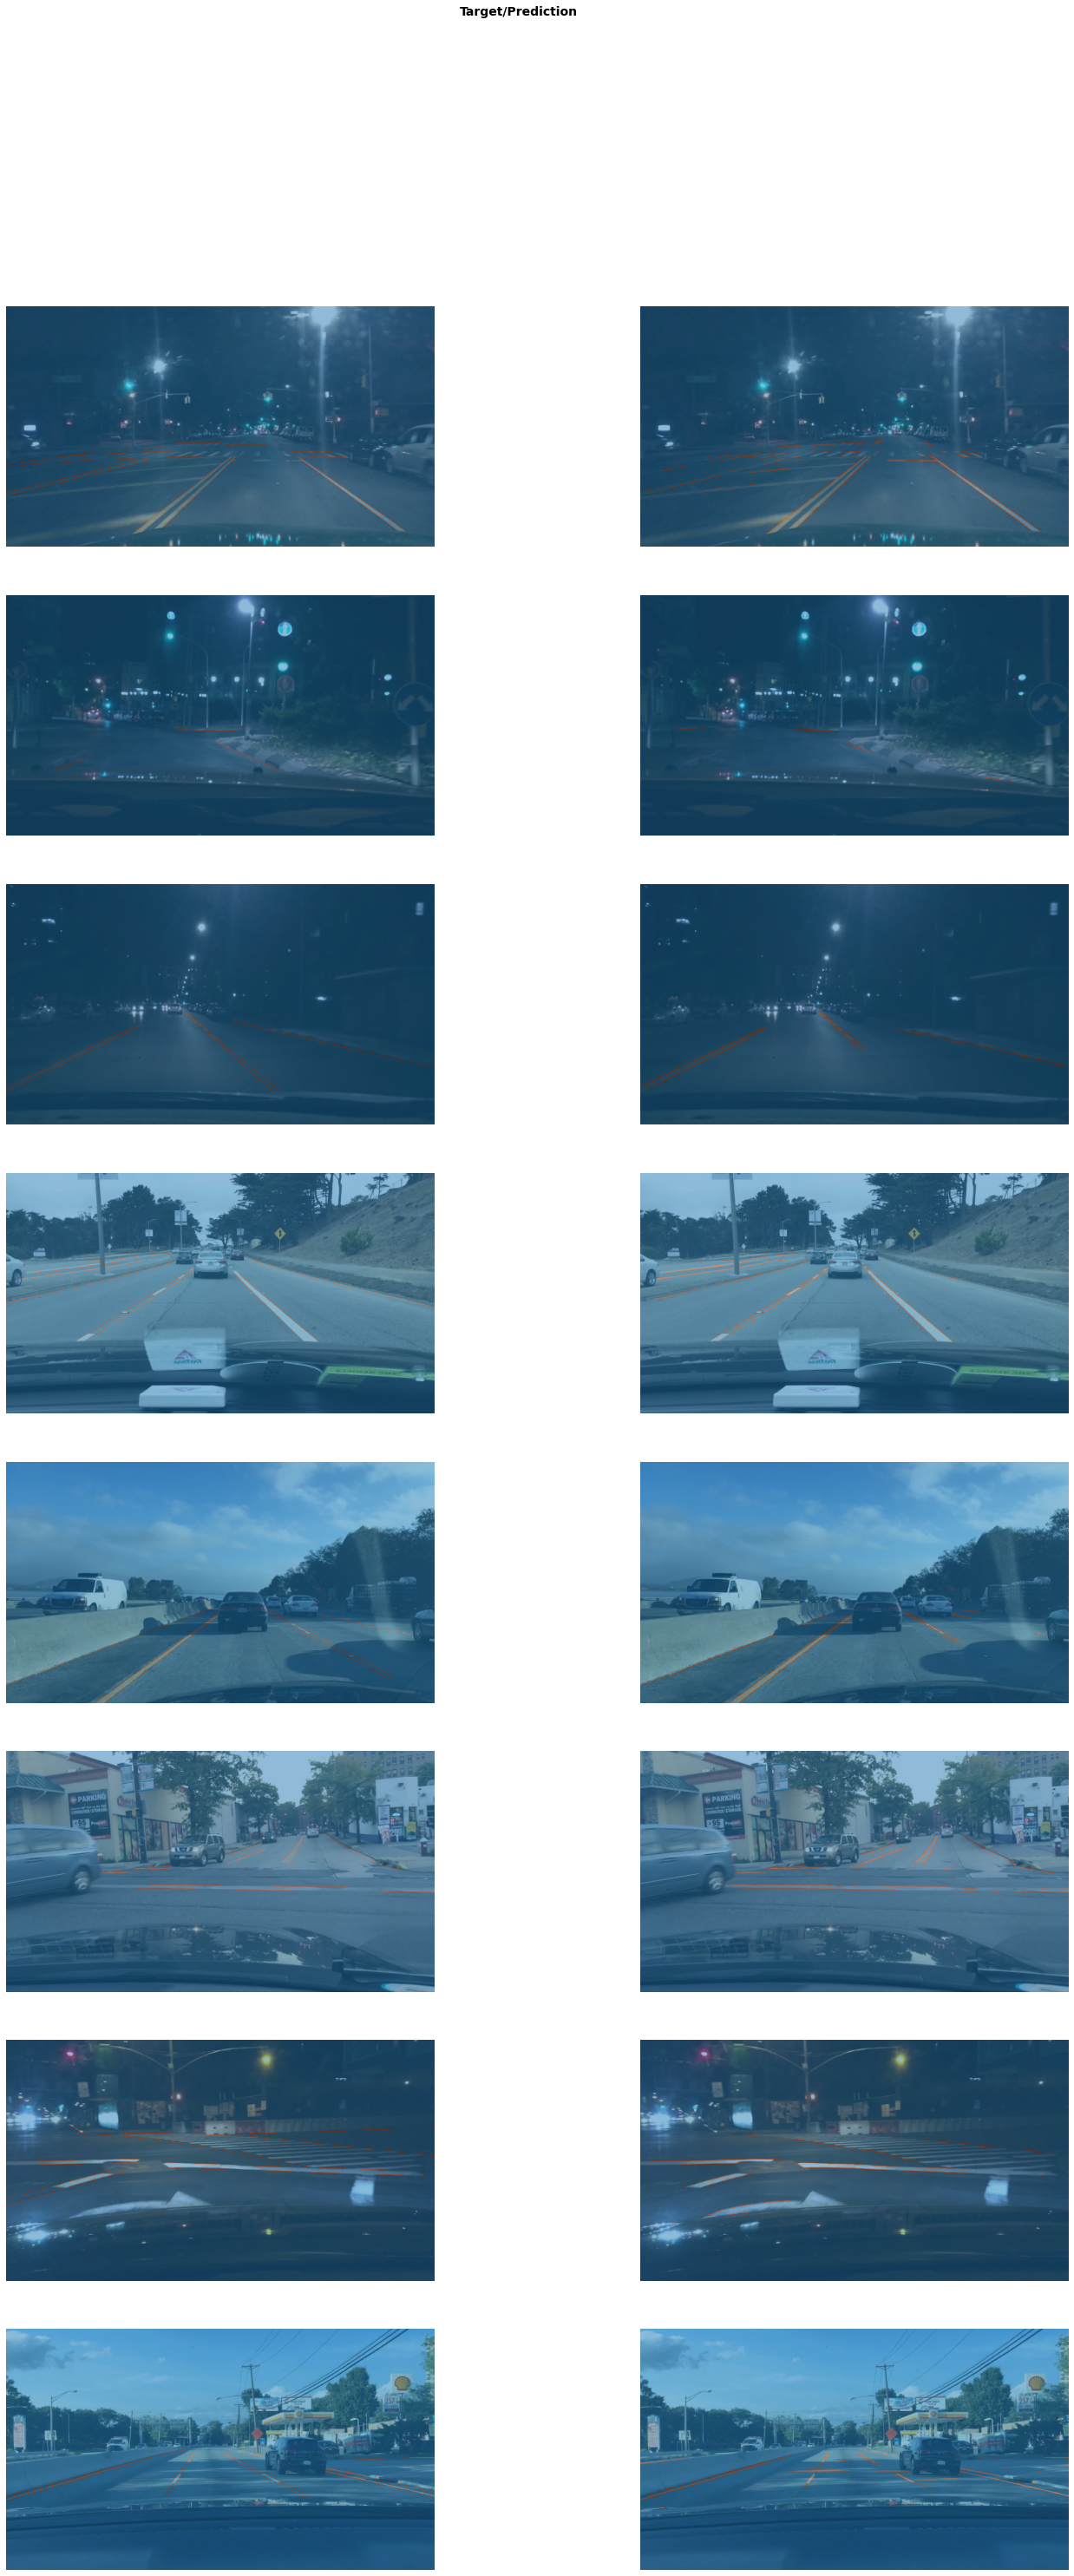

In [ ]:
learn.show_results(max_n=8, figsize=(24,48))

In [ ]:
idx = 6
log_dict = {}
log_dict['learn'] = learn

In [ ]:
#base_pth

'/content/drive/MyDrive/binary_lane_bdd'

In [ ]:
#learn.save(base_pth + '/results/model_{}'.format(idx))

Path('/content/drive/MyDrive/binary_lane_bdd/results/model_6.pth')

#### Inference

In [367]:
learn.load(base_pth+'/results/model_6')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


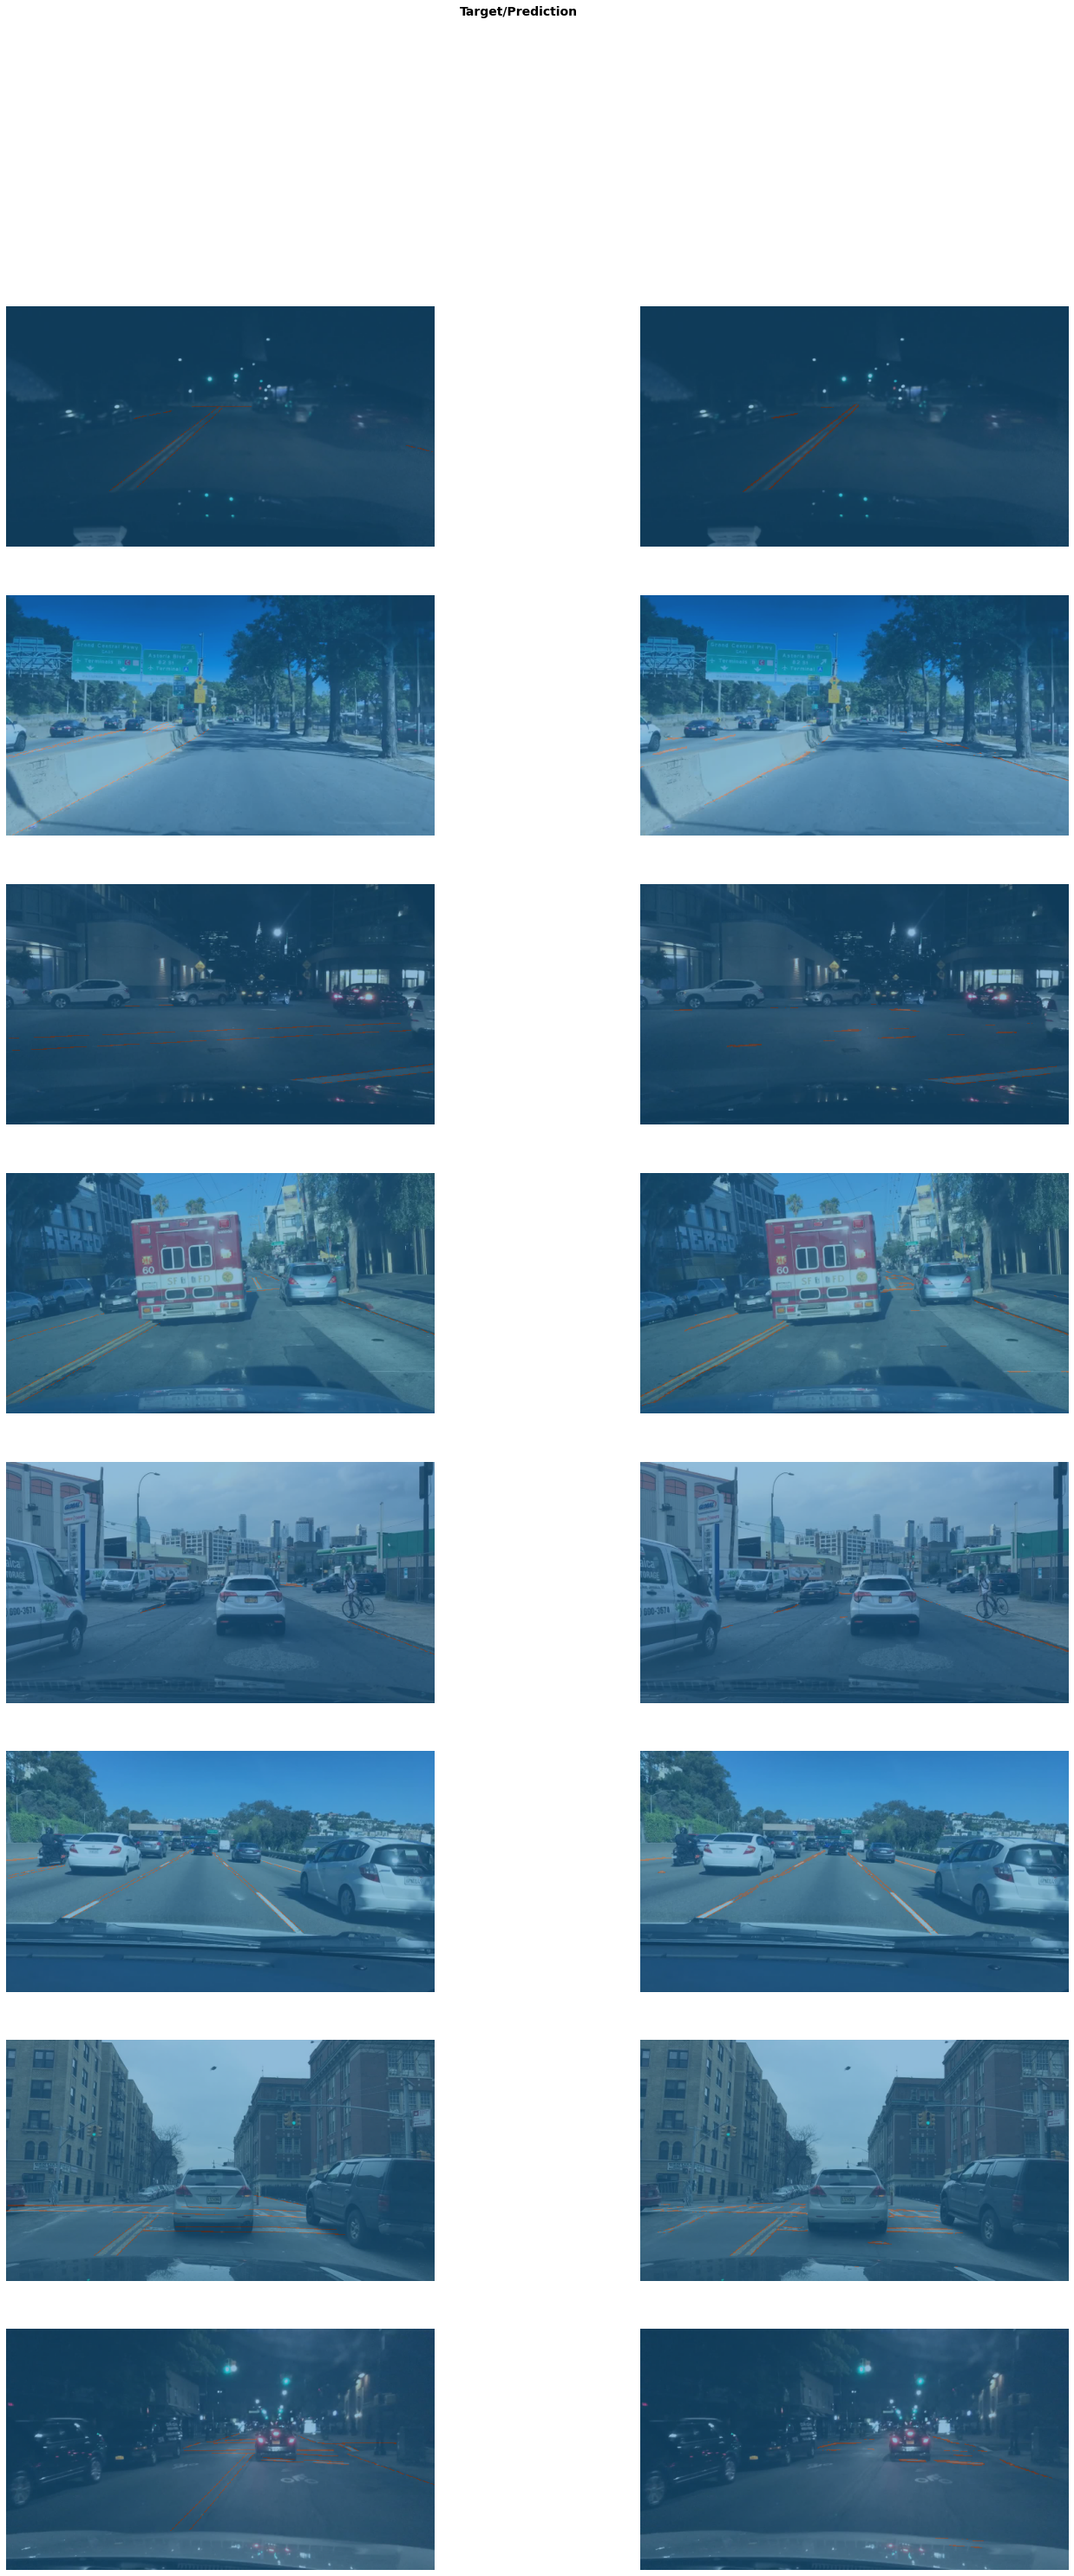

In [370]:
learn.show_results(max_n=8, figsize=(24,48))

In [363]:
dl = dls_tst.test_dl(test_items = tst_fnames, with_labels=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


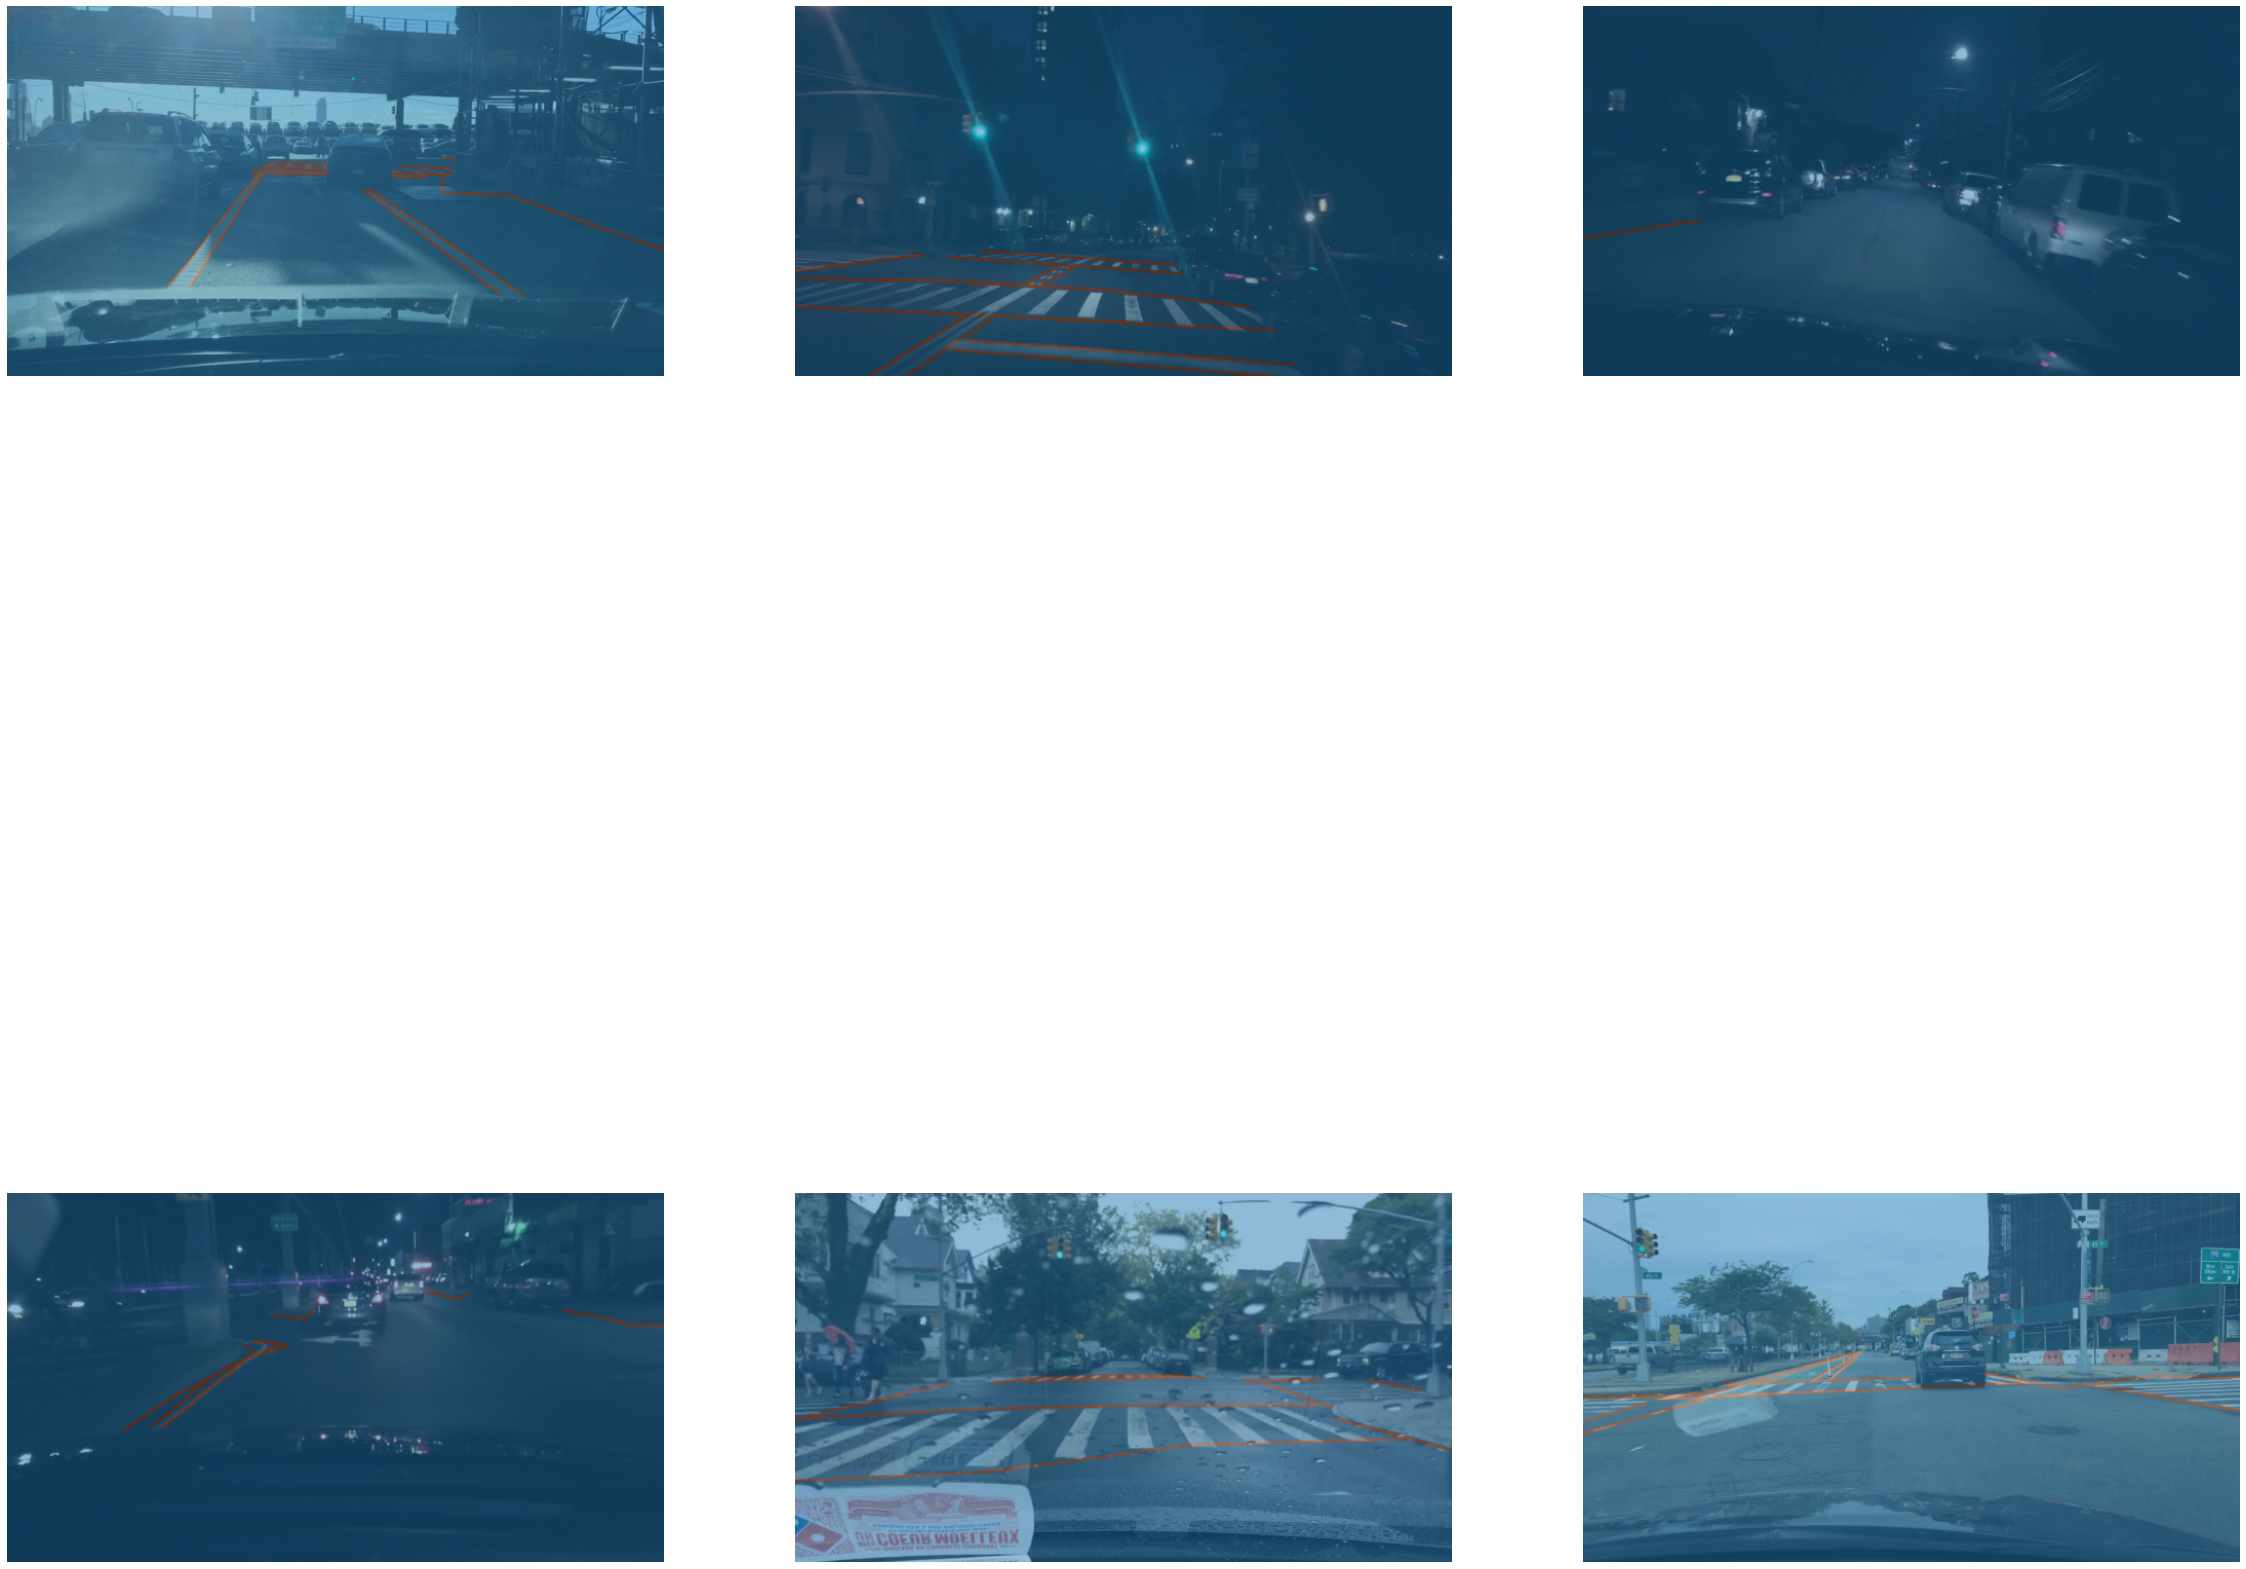

In [364]:
dl.show_batch(max_n= 6, figsize = (24,48))

In [371]:
print('Jaccard Coefficient : {}'.format(compute_val(JaccardCoeff(), cast(preds, TensorImage), cast(targs, TensorMask))))
print('Dice : {}'.format(compute_val(Dice(), cast(preds, TensorImage), cast(targs, TensorMask))))
print('FG Accuracy : {}'.format(fg_accuracy(preds, targs)))
print('BG Accuracy : {}'.format(bg_accuracy(preds, targs)))

Jaccard Coefficient : 0.2674524121048411
Dice : 0.42203148544360175
FG Accuracy : 0.3162895739078522
BG Accuracy : 0.9973511099815369


In [374]:
test_results = []
for idx in tqdm_notebook(range(501)):
  jcf = compute_val(JaccardCoeff(), cast(preds[idx].reshape(1,2,360,640), TensorImage), cast(targs[idx].reshape(1,360,640), TensorMask))
  dice = compute_val(Dice(), cast(preds[idx].reshape(1,2,360,640), TensorImage), cast(targs[idx].reshape(1,360,640), TensorMask))
  fga = fg_accuracy(preds[idx].reshape(1,2,360,640), targs[idx].reshape(1,360,640))
  bga = bg_accuracy(preds[idx].reshape(1,2,360,640), targs[idx].reshape(1,360,640))
  test_results.append([idx, tst_fnames[idx], jcf, dice, fga, bga])
test_results = pd.DataFrame(test_results, columns = ['index', 'path', 'iou', 'dice', 'fg_acc', 'bg_acc'])
test_results = test_results.sort_values(by=['iou'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/501 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


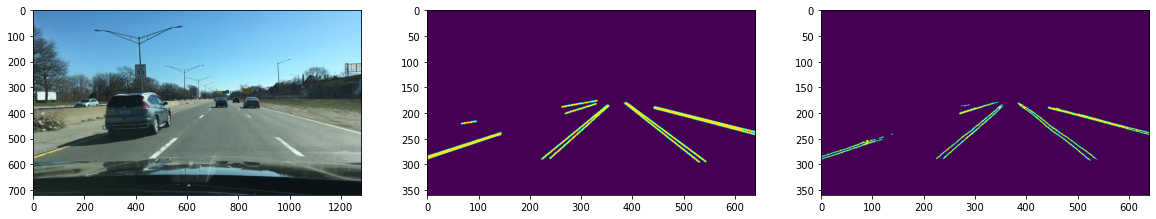

In [404]:
plot_test_results(dls_tst = dls_tst, fnames = tst_fnames, idx=186)